# Import all required libraries

In [8]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io, color
from skimage.transform import resize
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from sklearn.preprocessing import LabelEncoder
import shutil

# Exploring dataset

### Explore dataset garbage_classification_12_classes

In [ ]:
dataset_path = os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes')
classes = sorted(os.listdir(dataset_path))
print("Waste types:", classes)

Waste types: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [ ]:
data = []
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    num_images = len(os.listdir(class_path))
    data.append({"Class": class_name, "Number of images": num_images})

df_counts = pd.DataFrame(data)
print(df_counts)
print("Total sum", "                 ", df_counts["Number of images"].sum())

          Class  Number of images
0       battery               945
1    biological               985
2   brown-glass               607
3     cardboard               891
4       clothes              5325
5   green-glass               629
6         metal               769
7         paper              1050
8       plastic               865
9         shoes              1977
10        trash               697
11  white-glass               775
Total sum                   15515


In [ ]:
df_counts

Class  Number of images
0       battery               945
1    biological               985
2   brown-glass               607
3     cardboard               891
4       clothes              5325
5   green-glass               629
6         metal               769
7         paper              1050
8       plastic               865
9         shoes              1977
10        trash               697
11  white-glass               775

### Visualizations

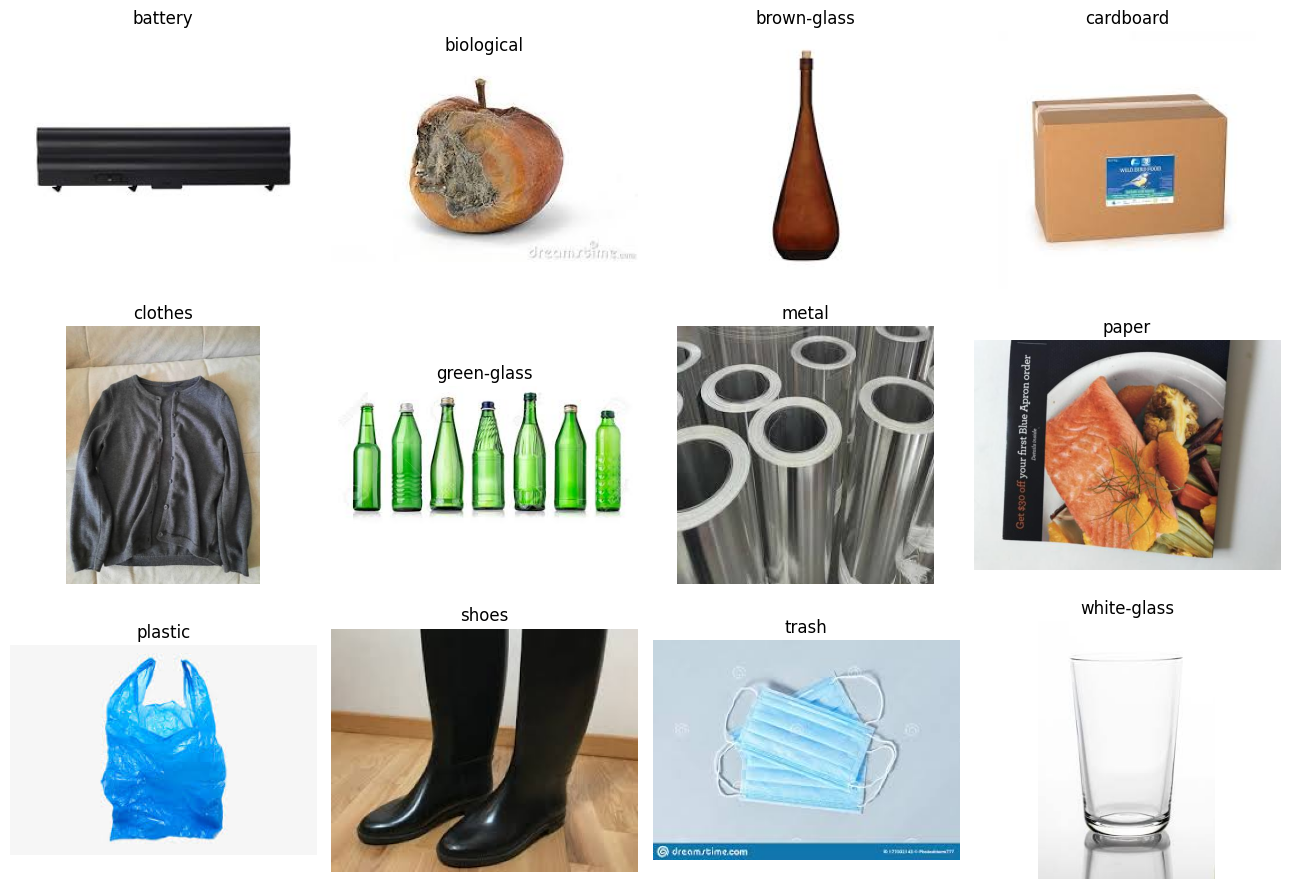

In [ ]:
plt.figure(figsize=(13, 9))
for i, class_name in enumerate(classes[:12]):  
    class_path = os.path.join(dataset_path, class_name)
    all_images = os.listdir(class_path)
    img_name = random.choice(all_images)
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    plt.subplot(3, 4, i+1)  
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

    
plt.tight_layout()
plt.show()

In [ ]:
# Open image with Pillow

# Select image
img = Image.open(os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes', 'battery', 'battery1.jpg'))

img_array = np.array(img)

# Dimensions
print("Size (width, high):", img.size)
print("channels:", len(img.getbands()))

# Visualize
img.show()  # Open image

Size (width, high): (280, 180)
channels: 3


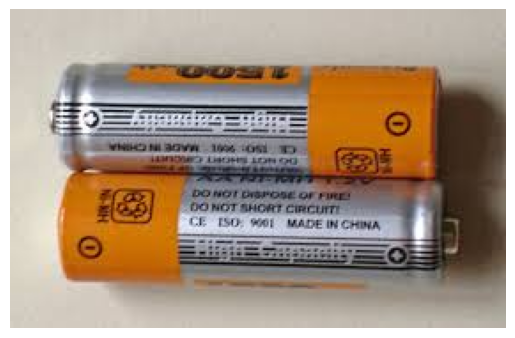

Shape (high, width, channels): (180, 280, 3)


In [ ]:
# Open image with matplotlib.image
img = mpimg.imread(os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes', 'battery', 'battery1.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()

# Dimensions
print("Shape (high, width, channels):", img.shape)

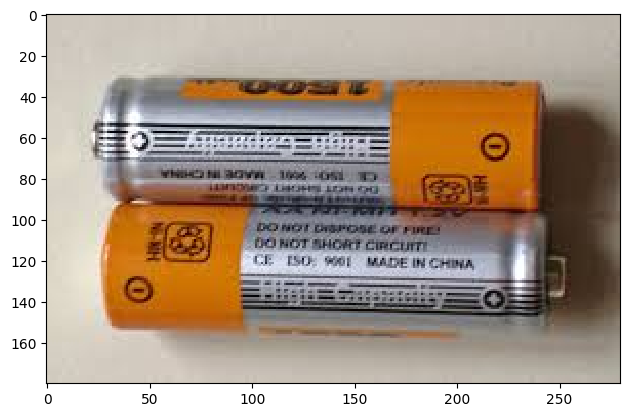

In [ ]:
# Open image with scikit-image

img = io.imread(os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes', 'battery', 'battery1.jpg'))

img_gray = color.rgb2gray(img)

img_resized = resize(img, (224, 224))

io.imshow(img)
io.show()

### Create Dataframe

In [ ]:
metadata = []

# Look for images and classes
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        
        # Open image and extract metadata
        with Image.open(img_path) as img:
            metadata.append({
                "image_path": img_path,
                "class": class_name,
                "width": img.width,
                "height": img.height,
                "channels": len(img.getbands()),
                "aspect_ratio": round(img.width / img.height, 2) # to see if the image is wider than tall, taller than wide or nearly square.
            })

df_metadata = pd.DataFrame(metadata)
df_metadata.head()

image_path    class  width  height  \
0  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  battery    280     180   
1  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  battery    220     165   
2  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  battery    275     183   
3  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  battery    275     183   
4  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  battery    224     224   

   channels  aspect_ratio  
0         3          1.56  
1         3          1.33  
2         3          1.50  
3         3          1.50  
4         3          1.00

### EDA

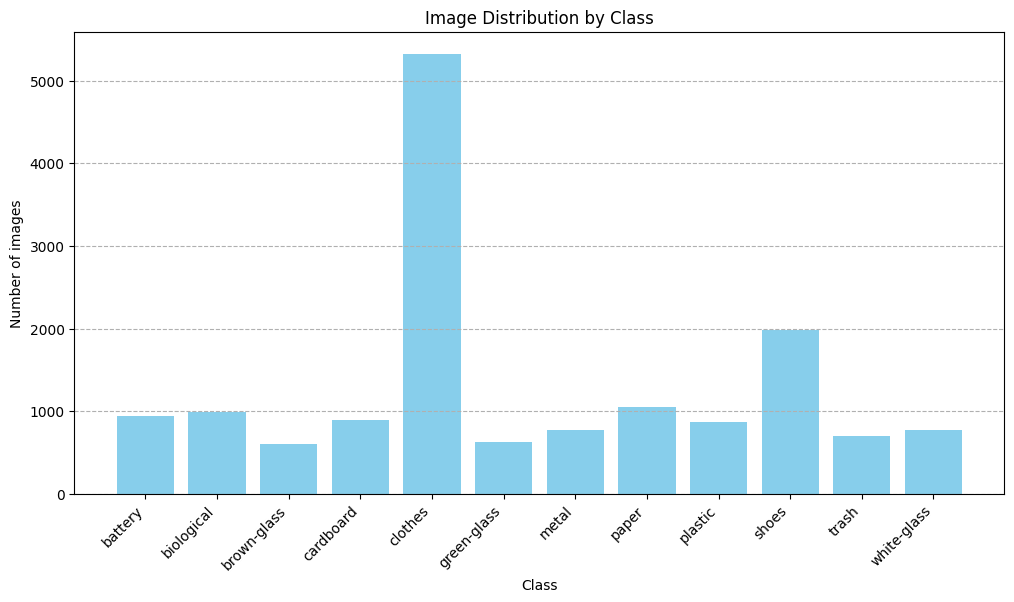

In [ ]:
class_counts = df_counts["Number of images"]
plt.figure(figsize=(12, 6))
plt.bar(classes, class_counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Image Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.grid(axis='y', linestyle='--')
plt.show()

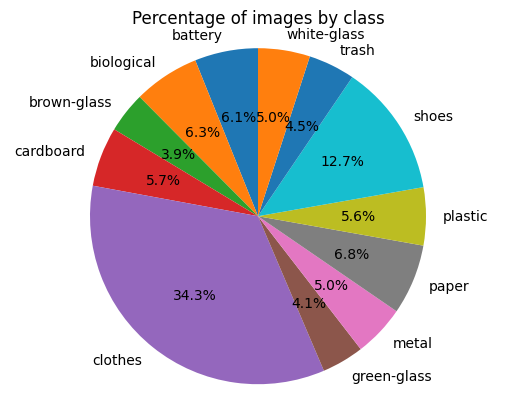

In [ ]:
plt.pie(class_counts, labels=classes, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Percentage of images by class")
plt.show()

C:\Users\ruben\AppData\Local\Temp\ipykernel_12948\2858734669.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_palette = plt.cm.get_cmap('viridis', len(classes))


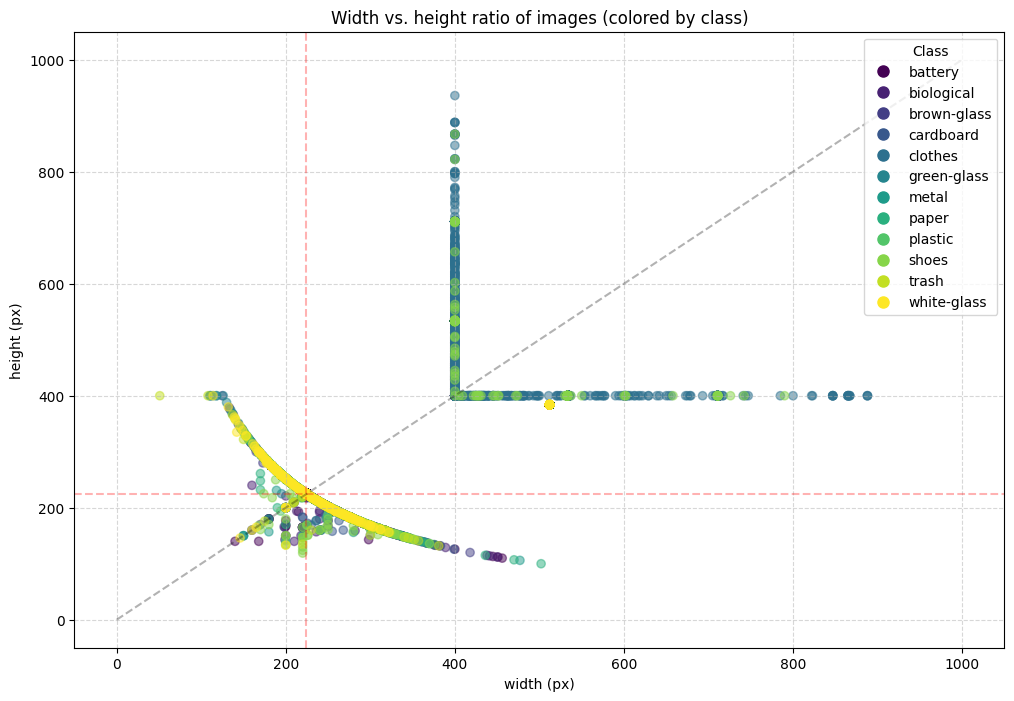

In [ ]:
plt.figure(figsize=(12, 8))
custom_palette = plt.cm.get_cmap('viridis', len(classes))
plt.scatter(
    df_metadata["width"], 
    df_metadata["height"], 
    alpha=0.5,
    c = pd.factorize(df_metadata["class"])[0],  # Color by class
    cmap = custom_palette
)

plt.axhline(y=224, color='r', linestyle='--', alpha=0.3,)
plt.axvline(x=224, color='r', linestyle='--', alpha=0.3)
plt.plot([0, 1000], [0, 1000], 'k--', alpha=0.3, label='1:1') 

plt.title("Width vs. height ratio of images (colored by class)")
plt.xlabel("width (px)")
plt.ylabel("height (px)")
legend_elements = [plt.Line2D([0], [0], marker='o', color=custom_palette(i), linestyle='', markersize=8, label=class_name)
                   for i, class_name in enumerate(classes)]

plt.legend(handles=legend_elements, title="Class", loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

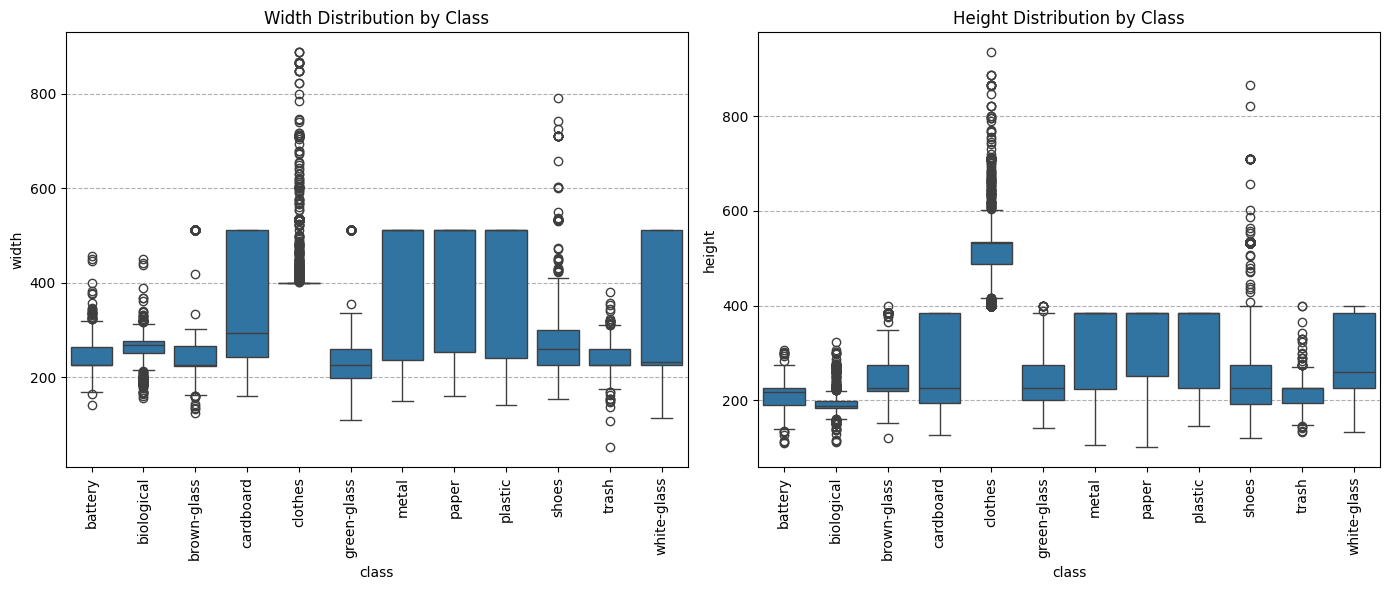

In [ ]:
plt.figure(figsize=(14, 6))

# Boxplot for width
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='width', data=df_metadata)
plt.xticks(rotation=90)
plt.title("Width Distribution by Class")
plt.grid(axis='y', linestyle='--')

# Boxplot for high
plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='height', data=df_metadata)
plt.xticks(rotation=90)
plt.title("Height Distribution by Class")
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# ResNet50 model (1st trial)

### Image resizing

In [ ]:
images = []
labels = []

# Target size for resizing images
IMG_SIZE = (224, 224)

# Mapping of class to numerical index
class_to_index = {class_name: i for i, class_name in enumerate(classes)}

# Resizing
for index, row in df_metadata.iterrows():
    img_path = row['image_path']
    class_name = row['class']

    with Image.open(img_path) as img:
        img = img.convert('RGB')  # Consistent Image Format
        img_resized = resize(np.array(img), IMG_SIZE, anti_aliasing=True).astype(np.float32)
        print(f"Range after resize for {img_path}: Min={img_resized.min()}, Max={img_resized.max()}") # Checking data already normalized
        images.append(img_resized)
        labels.append(class_to_index[class_name])

# Converting lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

print("Total number of images uploaded:", len(images))
print("Total number of labels loaded:", len(labels))
print("Image format:", images[0].shape)
print("Label format:", labels.shape)
print("Example of label (class index):", labels[0])
print("Class corresponding to index 0:", classes[0])

Range after resize for C:\Users\ruben\OneDrive\Escritorio\IRONHACK\final_project\datasets\garbage_classification_12_classes\garbage_classification\battery\battery1.jpg: Min=0.0, Max=1.0
Range after resize for C:\Users\ruben\OneDrive\Escritorio\IRONHACK\final_project\datasets\garbage_classification_12_classes\garbage_classification\battery\battery10.jpg: Min=0.005875240545719862, Max=1.0
Range after resize for C:\Users\ruben\OneDrive\Escritorio\IRONHACK\final_project\datasets\garbage_classification_12_classes\garbage_classification\battery\battery100.jpg: Min=0.0, Max=1.0
Range after resize for C:\Users\ruben\OneDrive\Escritorio\IRONHACK\final_project\datasets\garbage_classification_12_classes\garbage_classification\battery\battery101.jpg: Min=0.0, Max=1.0
Range after resize for C:\Users\ruben\OneDrive\Escritorio\IRONHACK\final_project\datasets\garbage_classification_12_classes\garbage_classification\battery\battery102.jpg: Min=0.0, Max=1.0
Range after resize for C:\Users\ruben\OneDrive

### Dividing dataset into training, validation and test

In [ ]:
# Split into training and validation/test (80% training).
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Divide the validation and test (10% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(y_train, num_classes=len(classes))
y_val_encoded = to_categorical(y_val, num_classes=len(classes))
y_test_encoded = to_categorical(y_test, num_classes=len(classes))

print("Training set size:", X_train.shape)
print("Size of training labels:", y_train_encoded.shape)
print("Validation set size:", X_val.shape)
print("Size of validation tags:", y_val_encoded.shape)
print("Test set size:", X_test.shape)
print("Size of test labels:", y_test_encoded.shape)

Training set size: (12412, 224, 224, 3)
Size of training labels: (12412, 12)
Validation set size: (1551, 224, 224, 3)
Size of validation tags: (1551, 12)
Test set size: (1552, 224, 224, 3)
Size of test labels: (1552, 12)


### ResNet50 Model (pre-trained base model)

In [ ]:
# Load the pre-trained base model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base model layers to prevent training
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(500, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Show model architecture
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Apply ResNet50-specific preprocessing
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
callbacks = [early_stopping, lr_scheduler]

# Training the model
epochs = 50
batch_size = 32

history = model.fit(
    X_train,
    y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/50
388/388 [==============================] - 579s 1s/step - loss: 2.0327 - accuracy: 0.3774 - val_loss: 1.8432 - val_accuracy: 0.4371 - lr: 1.0000e-04
Epoch 2/50
388/388 [==============================] - 573s 1s/step - loss: 1.6605 - accuracy: 0.4857 - val_loss: 2.1050 - val_accuracy: 0.4275 - lr: 1.0000e-04
Epoch 3/50
388/388 [==============================] - 7204s 19s/step - loss: 1.5398 - accuracy: 0.5193 - val_loss: 2.1679 - val_accuracy: 0.3282 - lr: 1.0000e-04
Epoch 4/50
388/388 [==============================] - 929s 2s/step - loss: 1.4723 - accuracy: 0.5393 - val_loss: 1.5814 - val_accuracy: 0.5035 - lr: 1.0000e-04
Epoch 5/50
388/388 [==============================] - 594s 2s/step - loss: 1.4156 - accuracy: 0.5483 - val_loss: 1.4375 - val_accuracy: 0.5693 - lr: 1.0000e-04
Epoch 6/50
388/388 [==============================] - 607s 2s/step - loss: 1.3723 - accuracy: 0.5651 - val_loss: 1.5206 - val_accuracy: 0.5416 - lr: 1.0000e-04
Epoch 7/50
388/388 [==================

### Evaluating model

In [ ]:
# Evaluate the model on the test
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Loss in the test: {loss:.4f}")
print(f"Accuracy in the test: {accuracy:.4f}")

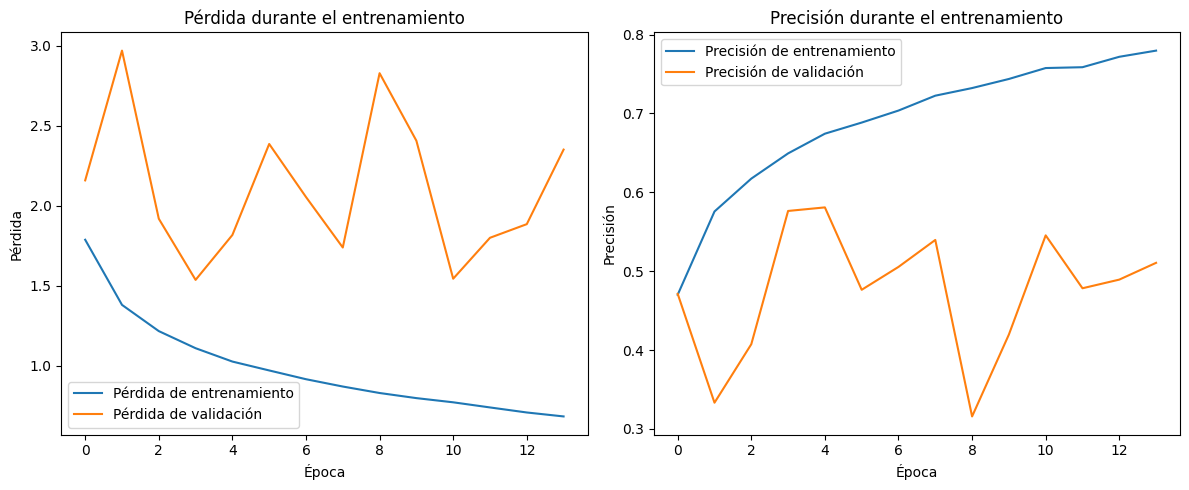

In [ ]:
# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

49/49 [==============================] - 67s 1s/step


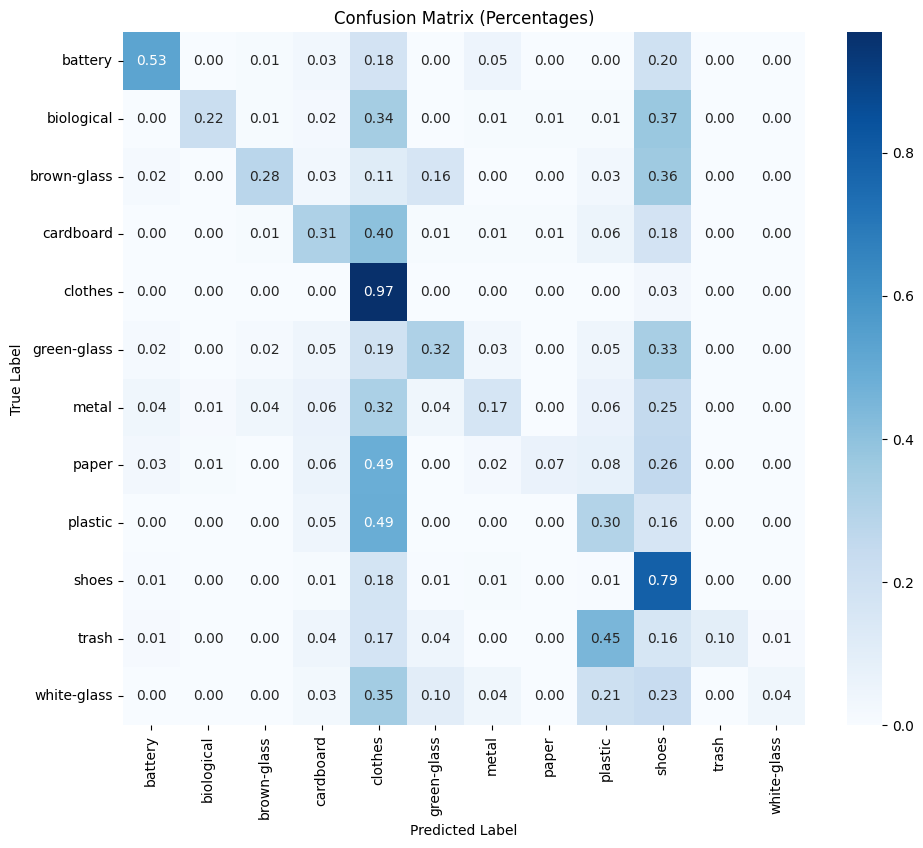

In [ ]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_encoded, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(11, 9))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages)')
plt.show()

### Visualize possible image discrepancies between classes differences

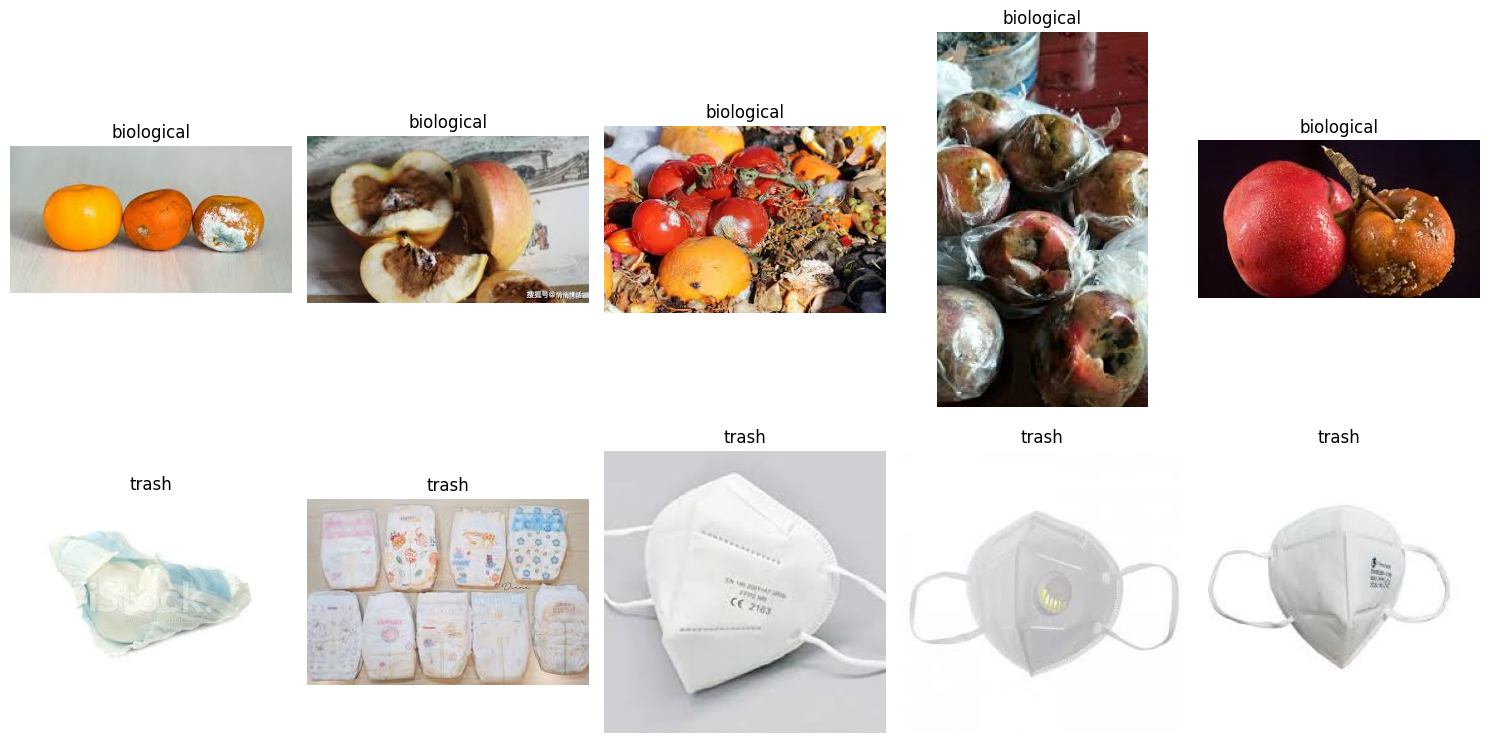

In [ ]:
classes_to_visualize = ["biological", "trash"]
num_images_per_class = 5  

plt.figure(figsize=(15, 8))

for i, class_name in enumerate(classes_to_visualize):
    class_path = os.path.join(dataset_path, class_name)
    all_images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))] 
    random_images = random.sample(all_images, num_images_per_class)
    for j, img_name in enumerate(random_images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(len(classes_to_visualize), num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# ResNet50 model with enhancements (reduced to 10 classes)

In [ ]:
dataset_path = os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes', 'battery', 'battery1.jpg')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42
EXCLUDED_CLASSES = ['clothes', 'shoes']

# Get the list of classes, excluding the specified ones
all_classes = sorted(os.listdir(dataset_path))
classes = [c for c in all_classes if c not in EXCLUDED_CLASSES]
print("Waste types (excluding clothes and shoes):", classes)

Waste types (excluding clothes and shoes): ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']


### Create Dataframe

In [ ]:
metadata = []
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            metadata.append({"image_path": img_path, "class": class_name})

df_metadata = pd.DataFrame(metadata)

### Split data

In [ ]:
# Split data
train_df, temp_df = train_test_split(df_metadata, test_size=0.2, random_state=SEED, stratify=df_metadata['class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['class'])

### ImageDataGenerator

In [ ]:
# ImageDataGenerator for training with augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    seed=SEED,
    shuffle=True
)

# ImageDataGenerator for validation (only preprocessing)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    seed=SEED,
    shuffle=False
)

# ImageDataGenerator for test (only preprocessing)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    seed=SEED,
    shuffle=False
)

Found 6570 validated image filenames belonging to 10 classes.
Found 821 validated image filenames belonging to 10 classes.
Found 822 validated image filenames belonging to 10 classes.


### Training model

In [ ]:
# Load the pre-trained base model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# ModelCheckpoint to save the best model based on validation loss
checkpoint_filepath = 'best_model_10_classes.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=False,
    mode='min', 
    verbose=1
)

callbacks_list = [early_stopping, lr_scheduler, model_checkpoint_callback]

# Training the model with generators
epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

# Evaluate the model on the test generator
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50
205/205 [==============================] - ETA: 0s - loss: 2.1801 - accuracy: 0.2560
Epoch 1: val_loss improved from inf to 2.20638, saving model to best_model_10_classes.h5
205/205 [==============================] - 247s 1s/step - loss: 2.1801 - accuracy: 0.2560 - val_loss: 2.2064 - val_accuracy: 0.1863 - lr: 1.0000e-04
Epoch 2/50
205/205 [==============================] - ETA: 0s - loss: 1.9708 - accuracy: 0.3243
Epoch 2: val_loss improved from 2.20638 to 2.19107, saving model to best_model_10_classes.h5
205/205 [==============================] - 262s 1s/step - loss: 1.9708 - accuracy: 0.3243 - val_loss: 2.1911 - val_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 3/50
205/205 [==============================] - ETA: 0s - loss: 1.9002 - accuracy: 0.3568
Epoch 3: val_loss improved from 2.19107 to 2.06147, saving model to best_model_10_classes.h5
205/205 [==============================] - 298s 1s/step - loss: 1.9002 - accuracy: 0.3568 - val_loss: 2.0615 - val_accuracy: 0.3313 - lr: 1

### Evaluating model

In [ ]:
# Load the best saved model
best_model = load_model('best_model_10_classes.h5')

# Evaluate the model in the test generator
loss, accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report using test_generator
y_pred_probs = best_model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for i in range(test_generator.samples // BATCH_SIZE):
    _, labels = test_generator[i]
    y_true.extend(np.argmax(labels, axis=1))
y_true = np.array(y_true)

report = classification_report(y_true, y_pred, target_names=classes, zero_division=0)
print("Classification Report (Test Set):\n", report)

25/25 [==============================] - 28s 1s/step - loss: 1.5209 - accuracy: 0.5238
Test Loss: 1.5209
Test Accuracy: 0.5238
25/25 [==============================] - 28s 1s/step
Classification Report (Test Set):
               precision    recall  f1-score   support

     battery       0.63      0.76      0.69        94
  biological       0.71      0.56      0.62        98
 brown-glass       0.56      0.39      0.46        57
   cardboard       0.55      0.66      0.60        88
 green-glass       0.61      0.57      0.59        60
       metal       0.32      0.28      0.30        72
       paper       0.56      0.64      0.60       101
     plastic       0.34      0.42      0.38        83
       trash       0.52      0.47      0.49        70
 white-glass       0.39      0.34      0.36        77

    accuracy                           0.52       800
   macro avg       0.52      0.51      0.51       800
weighted avg       0.53      0.52      0.52       800



In [ ]:
loss_val, accuracy_val = best_model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE, verbose=0)
print(f"Validation Loss: {loss_val:.4f}")
print(f"Validation Accuracy: {accuracy_val:.4f}")

y_pred_val_probs = best_model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
y_pred_val = np.argmax(y_pred_val_probs, axis=1)

y_true_val = []
for i in range(validation_generator.samples // BATCH_SIZE):
    _, labels = validation_generator[i]
    y_true_val.extend(np.argmax(labels, axis=1))
y_true_val = np.array(y_true_val)

report_val = classification_report(y_true_val, y_pred_val, target_names=classes, zero_division=0)
print("Classification Report (Validation Set):\n", report_val)

Validation Loss: 1.5295
Validation Accuracy: 0.5025
25/25 [==============================] - 30s 1s/step
Classification Report (Validation Set):
               precision    recall  f1-score   support

     battery       0.69      0.78      0.73        92
  biological       0.69      0.52      0.60        96
 brown-glass       0.53      0.51      0.52        59
   cardboard       0.47      0.55      0.51        86
 green-glass       0.57      0.34      0.43        61
       metal       0.36      0.33      0.35        75
       paper       0.52      0.58      0.55       104
     plastic       0.41      0.48      0.44        86
       trash       0.44      0.45      0.45        64
 white-glass       0.34      0.35      0.34        77

    accuracy                           0.50       800
   macro avg       0.50      0.49      0.49       800
weighted avg       0.51      0.50      0.50       800



In [ ]:
train_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
train_generator_eval = train_datagen_eval.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    seed=SEED,
    shuffle=False  
)

loss_train, accuracy_train = best_model.evaluate(train_generator_eval, steps=train_generator_eval.samples // BATCH_SIZE, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {accuracy_train:.4f}")

y_pred_train_probs = best_model.predict(train_generator_eval, steps=train_generator_eval.samples // BATCH_SIZE)
y_pred_train = np.argmax(y_pred_train_probs, axis=1)
y_true_train = train_generator_eval.classes[:len(y_pred_train)]
report_train = classification_report(y_true_train, y_pred_train, target_names=classes, zero_division=0)
print("Classification Report (Training Set):\n", report_train)

Found 6570 validated image filenames belonging to 10 classes.
Train Loss: 1.4225
Train Accuracy: 0.5351
205/205 [==============================] - 247s 1s/step
Classification Report (Training Set):
               precision    recall  f1-score   support

     battery       0.67      0.76      0.71       756
  biological       0.73      0.60      0.66       788
 brown-glass       0.54      0.52      0.53       484
   cardboard       0.51      0.64      0.57       712
 green-glass       0.57      0.40      0.47       502
       metal       0.41      0.34      0.37       614
       paper       0.54      0.58      0.56       838
     plastic       0.40      0.45      0.42       692
       trash       0.55      0.59      0.57       556
 white-glass       0.39      0.35      0.37       618

    accuracy                           0.54      6560
   macro avg       0.53      0.52      0.52      6560
weighted avg       0.54      0.54      0.53      6560



### Training Loss and Accuracy

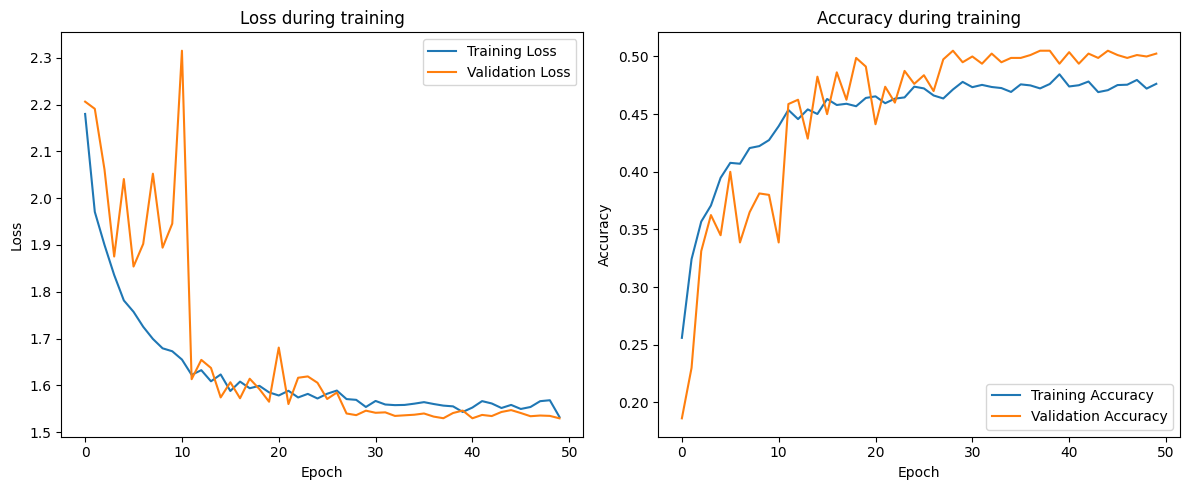

In [ ]:
# Loss and accuracy visualization during the training model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Confusion matrix

Found 822 validated image filenames belonging to 10 classes.
25/25 [==============================] - 33s 1s/step


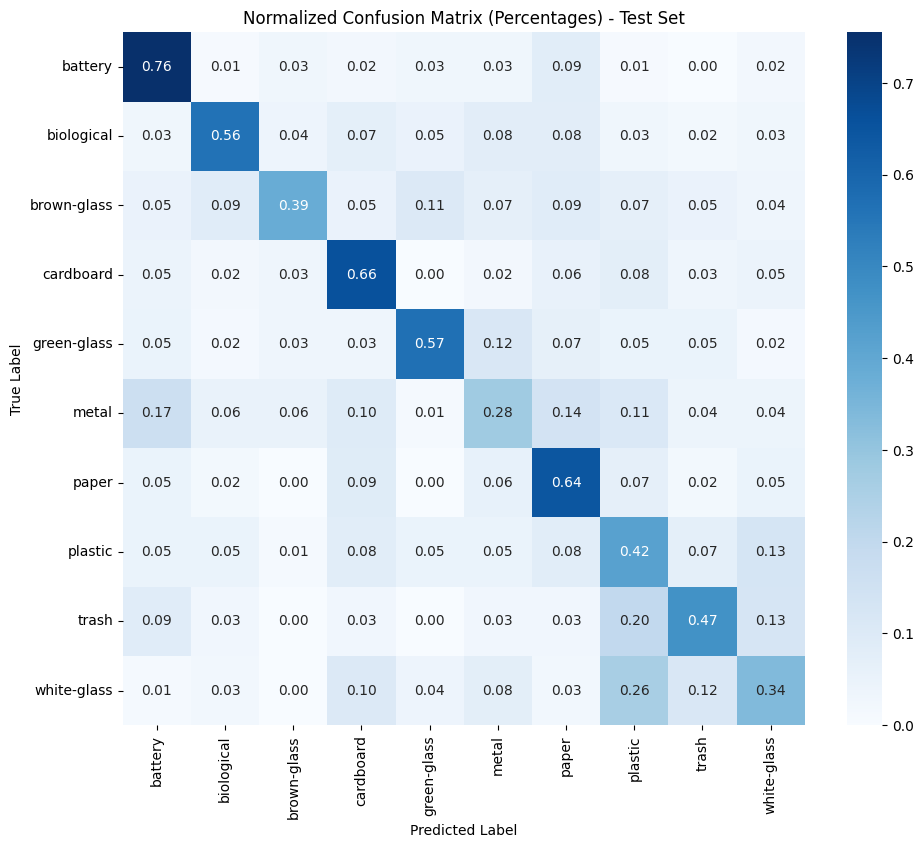

In [ ]:
classes = ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass'] 

# ImageDataGenerator for Test Set Evaluation
test_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator_eval = test_datagen_eval.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    seed=SEED,
    shuffle=False
)

# Obtain Predictions and True Tags for the Test Set
y_pred_test_probs = best_model.predict(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE)
y_pred_test = np.argmax(y_pred_test_probs, axis=1)
y_true_test = test_generator_eval.classes[:len(y_pred_test)]

# Calculate and Display the Normalized Confusion Matrix
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_normalized_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(11, 9))
sns.heatmap(cm_normalized_test, annot=True, fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Percentages) - Test Set')
plt.show()

## Getting visualizations for comparison, mapping to 7 and 3 classes

### Mapping and evaluating to 7 classes

In [ ]:
original_classes = ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']
class_mapping = {
    'biological': 'trash',
    'brown-glass': 'glass',
    'battery': 'battery',
    'cardboard': 'cardboard',
    'green-glass': 'glass',
    'metal': 'metal',
    'paper': 'paper',
    'plastic': 'plastic',
    'trash': 'trash',
    'white-glass': 'glass'
}
mapped_classes = sorted(list(set(class_mapping.values())))
num_mapped_classes = len(mapped_classes)

# ImageDataGenerator for Test Set Evaluation
test_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator_eval = test_datagen_eval.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=original_classes, 
    seed=SEED,
    shuffle=False
)

# Evaluation of the Model in the Test Set (before mapping)
loss_before, accuracy_before = best_model.evaluate(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss (before mapping): {loss_before:.4f}")
print(f"Test Accuracy (before mapping): {accuracy_before:.4f}")

# Obtain Predictions and True Tags for the Test Set
y_pred_probs = best_model.predict(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE)
y_pred_original = np.argmax(y_pred_probs, axis=1)
y_true_original = test_generator_eval.classes[:len(y_pred_original)]

# Mapping True and Predicted Tags to New Classes
y_mapped_true = np.array([mapped_classes.index(class_mapping[original_classes[label]]) for label in y_true_original])
y_mapped_pred = np.array([mapped_classes.index(class_mapping[original_classes[label]]) for label in y_pred_original])

# Evaluation of the Model in the Test Set (after mapping)
from sklearn.metrics import accuracy_score
accuracy_after = accuracy_score(y_mapped_true, y_mapped_pred)
print(f"Test Accuracy (after mapping): {accuracy_after:.4f}")

# Ranking Report (after mapping)
report_mapped = classification_report(y_mapped_true, y_mapped_pred, target_names=mapped_classes, zero_division=0)
print("Classification Report (Test Set - after mapping):\n", report_mapped)

Found 822 validated image filenames belonging to 10 classes.
25/25 [==============================] - 34s 1s/step - loss: 1.5209 - accuracy: 0.5238
Test Loss (before mapping): 1.5209
Test Accuracy (before mapping): 0.5238
25/25 [==============================] - 36s 1s/step
Test Accuracy (after mapping): 0.5463
Classification Report (Test Set - after mapping):
               precision    recall  f1-score   support

     battery       0.63      0.76      0.69        94
   cardboard       0.55      0.66      0.60        88
       glass       0.60      0.49      0.54       194
       metal       0.32      0.28      0.30        72
       paper       0.56      0.64      0.60       101
     plastic       0.34      0.42      0.38        83
       trash       0.65      0.55      0.59       168

    accuracy                           0.55       800
   macro avg       0.52      0.54      0.53       800
weighted avg       0.55      0.55      0.54       800



Found 822 validated image filenames belonging to 10 classes.
25/25 [==============================] - 27s 1s/step


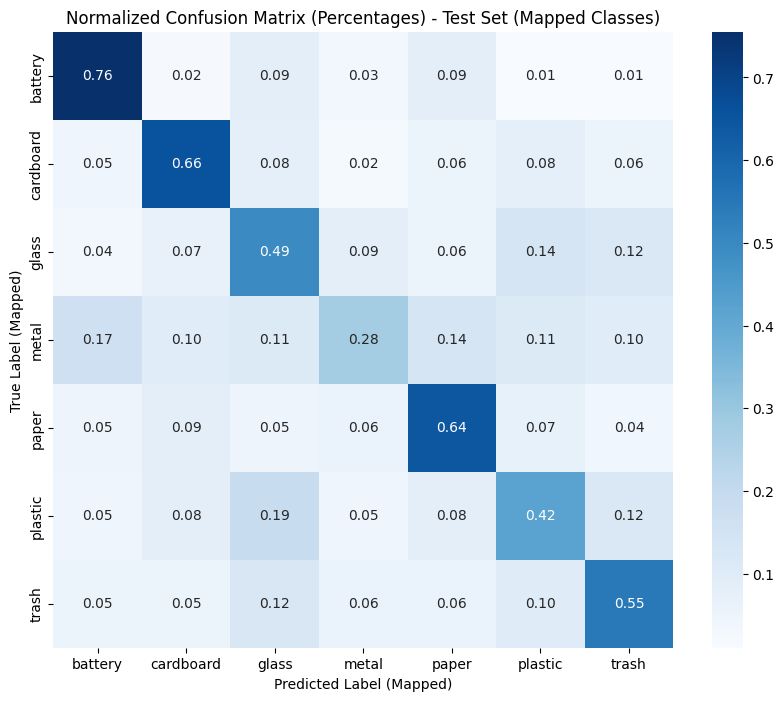

In [ ]:
# Calculate the Confusion Matrix (with the mapped classes)
cm_mapped = confusion_matrix(y_mapped_true, y_mapped_pred)

# Normalize the Confusion Matrix to show Percentages
cm_normalized_mapped = cm_mapped.astype('float') / cm_mapped.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized_mapped, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=mapped_classes, yticklabels=mapped_classes)
plt.xlabel('Predicted Label (Mapped)')
plt.ylabel('True Label (Mapped)')
plt.title('Normalized Confusion Matrix (Percentages) - Test Set (Mapped Classes)')
plt.show()

### Mapping and evaluating to 3 classes

In [ ]:
original_classes = ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']
class_mapping3 = {
    'brown-glass': 'glass',
    'green-glass': 'glass',
    'white-glass': 'glass',
    'cardboard': 'paper',
    'paper': 'paper',
    'metal': 'plastic',
    'plastic': 'plastic',
    'battery': 'other',         
    'biological': 'other',      
    'trash': 'other'
}
mapped3_classes = sorted(list(set(class_mapping3.values())))
num_mapped3_classes = len(mapped3_classes)

# ImageDataGenerator for Test Set Evaluation
test_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator_eval = test_datagen_eval.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=original_classes,
    seed=SEED,
    shuffle=False
)

# Evaluation of the Model in the Test Set
loss_before, accuracy_before = best_model.evaluate(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss (before mapping): {loss_before:.4f}")
print(f"Test Accuracy (before mapping): {accuracy_before:.4f}")

# Obtain Predictions and True labels for the Test Set
y_pred_probs = best_model.predict(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE)
y_pred_original = np.argmax(y_pred_probs, axis=1)
y_true_original = test_generator_eval.classes[:len(y_pred_original)]

# Mapping True and Predicted Tags to New Classes
y_mapped3_true = np.array([mapped3_classes.index(class_mapping3[original_classes[label]]) for label in y_true_original])
y_mapped3_pred = np.array([mapped3_classes.index(class_mapping3[original_classes[label]]) for label in y_pred_original])

# Evaluation of the Model in the Test Set (after mapping)
from sklearn.metrics import accuracy_score
accuracy_after = accuracy_score(y_mapped3_true, y_mapped3_pred)
print(f"Test Accuracy (after mapping): {accuracy_after:.4f}")

# Ranking Report (after mapping)
report_mapped3 = classification_report(y_mapped3_true, y_mapped3_pred, target_names=mapped3_classes, zero_division=0)
print("Classification Report (Test Set - after mapping):\n", report_mapped3)

Found 822 validated image filenames belonging to 10 classes.
25/25 [==============================] - 33s 1s/step - loss: 1.5209 - accuracy: 0.5238
Test Loss (before mapping): 1.5209
Test Accuracy (before mapping): 0.5238
25/25 [==============================] - 36s 1s/step
Test Accuracy (after mapping): 0.5913
Classification Report (Test Set - after mapping):
               precision    recall  f1-score   support

       glass       0.60      0.49      0.54       194
       other       0.68      0.66      0.67       262
       paper       0.62      0.72      0.67       189
     plastic       0.41      0.43      0.42       155

    accuracy                           0.59       800
   macro avg       0.58      0.58      0.57       800
weighted avg       0.59      0.59      0.59       800



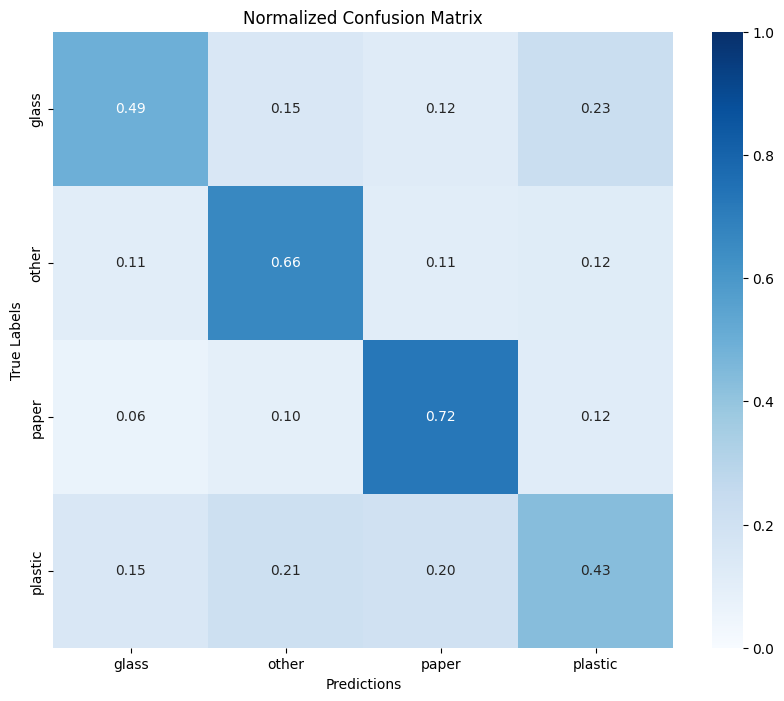

In [ ]:
# Normalized Confounding Matrix
cm = confusion_matrix(y_mapped3_true, y_mapped3_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm_normalized, 
                      annot=True, 
                      fmt='.2f',  
                      cmap='Blues', 
                      xticklabels=mapped3_classes, 
                      yticklabels=mapped3_classes,
                      vmin=0, 
                      vmax=1)  

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

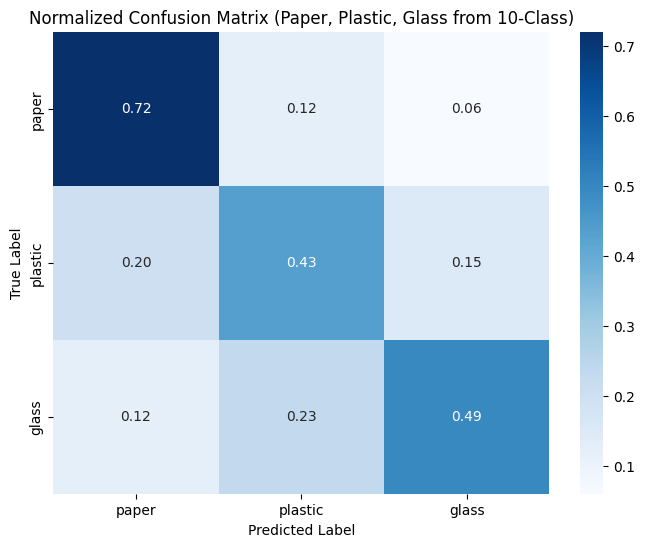

In [ ]:
classes = ['paper', 'plastic', 'glass']


personalized_matrix = np.array([
    
    [0.72 / (0.06 + 0.10 + 0.72 + 0.12),  
     0.12 / (0.06 + 0.10 + 0.72 + 0.12),  
     0.06 / (0.06 + 0.10 + 0.72 + 0.12)], 
    
    [0.20 / (0.15 + 0.21 + 0.20 + 0.43),  
     0.43 / (0.15 + 0.21 + 0.20 + 0.43),  
     0.15 / (0.15 + 0.21 + 0.20 + 0.43)], 
  
    [0.12 / (0.49 + 0.15 + 0.12 + 0.23), 
     0.23 / (0.49 + 0.15 + 0.12 + 0.23), 
     0.49 / (0.49 + 0.15 + 0.12 + 0.23)]  
])

plt.figure(figsize=(8, 6))
sns.heatmap(personalized_matrix,
            annot=True,
            fmt=".2f",
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Paper, Plastic, Glass from 10-Class)')
plt.show()

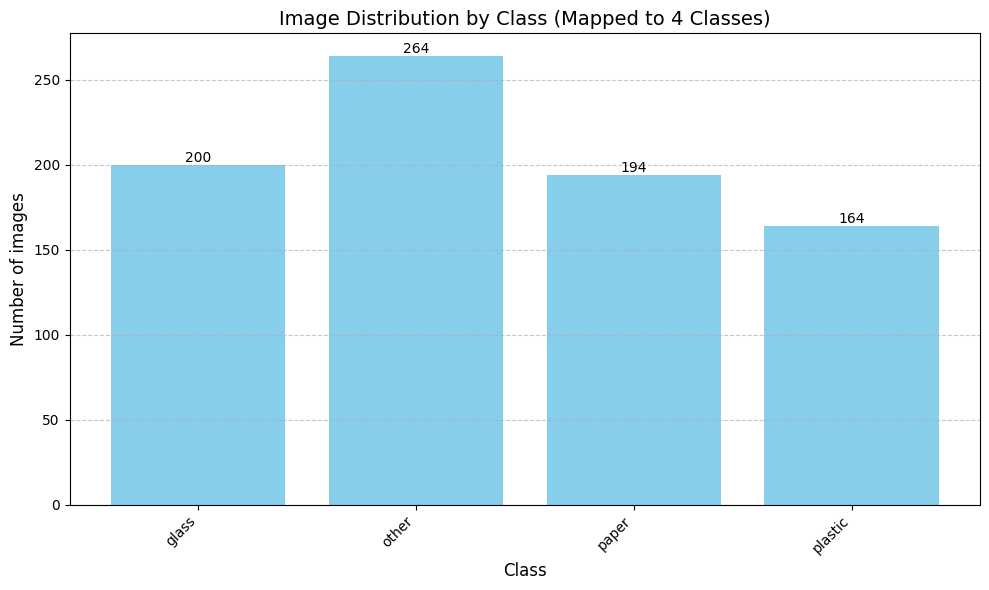

In [ ]:
# Map the original classes to the new 4 classes in the DataFrame
test_df['mapped_class'] = test_df['class'].map(class_mapping3)

# Count the number of images per mapped class
class_counts = test_df['mapped_class'].value_counts().reindex(mapped3_classes, fill_value=0)

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')

plt.title('Image Distribution by Class (Mapped to 4 Classes)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje X
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout() 
plt.show()

# ResNet50 model mapped to 7 classes

### Model preparation and trianing

In [3]:
dataset_path = os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42
EXCLUDED_CLASSES = ['clothes', 'shoes']

In [4]:
CLASS_MAPPING = {
    'battery': 'battery',
    'biological': 'trash',
    'brown-glass': 'glass',
    'cardboard': 'cardboard',
    'green-glass': 'glass',
    'metal': 'metal',
    'paper': 'paper',
    'plastic': 'plastic',
    'trash': 'trash',
    'white-glass': 'glass'
}

In [5]:
all_classes = sorted(os.listdir(dataset_path))
classes = [c for c in all_classes if c not in EXCLUDED_CLASSES]
print("Original classes (excluding clothes and shoes):", classes)

Original classes (excluding clothes and shoes): ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']


In [ ]:
metadata = []
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            metadata.append({"image_path": img_path, "class": class_name, "mapped_class": CLASS_MAPPING[class_name]})

df_metadata = pd.DataFrame(metadata)
new_classes = sorted(df_metadata['mapped_class'].unique())
print("\nClasses after mapping (7 classes):", new_classes)


Classes after mapping (7 classes): ['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
# Split data
train_df, temp_df = train_test_split(
    df_metadata, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=df_metadata['mapped_class']
)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=SEED, 
    stratify=temp_df['mapped_class']
)

In [ ]:
# Data generators with the new classes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="mapped_class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=new_classes,
    seed=SEED,
    shuffle=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rescale=1./255
)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="mapped_class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=new_classes,
    seed=SEED,
    shuffle=False
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="mapped_class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=new_classes,
    seed=SEED,
    shuffle=False
)

Found 6570 validated image filenames belonging to 7 classes.
Found 821 validated image filenames belonging to 7 classes.
Found 822 validated image filenames belonging to 7 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(new_classes), activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpoint_filepath = 'best_model_7_classes.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)
callbacks_list = [early_stopping, lr_scheduler, model_checkpoint]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50
205/205 [==============================] - ETA: 0s - loss: 1.8839 - accuracy: 0.3084
Epoch 1: val_loss improved from inf to 1.83019, saving model to best_model_7_classes.h5
205/205 [==============================] - 292s 1s/step - loss: 1.8839 - accuracy: 0.3084 - val_loss: 1.8302 - val_accuracy: 0.2425 - lr: 1.0000e-04
Epoch 2/50
205/205 [==============================] - ETA: 0s - loss: 1.6924 - accuracy: 0.3810
Epoch 2: val_loss improved from 1.83019 to 1.73489, saving model to best_model_7_classes.h5
205/205 [==============================] - 303s 1s/step - loss: 1.6924 - accuracy: 0.3810 - val_loss: 1.7349 - val_accuracy: 0.3375 - lr: 1.0000e-04
Epoch 3/50
205/205 [==============================] - ETA: 0s - loss: 1.6368 - accuracy: 0.4058
Epoch 3: val_loss did not improve from 1.73489
205/205 [==============================] - 337s 2s/step - loss: 1.6368 - accuracy: 0.4058 - val_loss: 1.9938 - val_accuracy: 0.3350 - lr: 1.0000e-04
Epoch 4/50
205/205 [==================

### Evaluating model

In [ ]:
best_model = load_model('best_model_7_classes.h5')

loss, accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_probs = best_model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for i in range(test_generator.samples // BATCH_SIZE):
    _, labels = test_generator[i]
    y_true.extend(np.argmax(labels, axis=1))
y_true = np.array(y_true)

report = classification_report(y_true, y_pred, target_names=new_classes, zero_division=0)
print("Classification Report (Test Set):\n", report)

25/25 [==============================] - 29s 1s/step - loss: 1.1641 - accuracy: 0.6012
Test Loss: 1.1641
Test Accuracy: 0.6012
25/25 [==============================] - 30s 1s/step
Classification Report (Test Set):
               precision    recall  f1-score   support

     battery       0.74      0.78      0.76        94
   cardboard       0.73      0.53      0.62        88
       glass       0.58      0.62      0.60       196
       metal       0.57      0.37      0.44        71
       paper       0.70      0.64      0.67       100
     plastic       0.39      0.40      0.39        83
       trash       0.57      0.70      0.63       168

    accuracy                           0.60       800
   macro avg       0.61      0.58      0.59       800
weighted avg       0.61      0.60      0.60       800



In [ ]:
loss_val, accuracy_val = best_model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE, verbose=0)
print(f"Validation Loss: {loss_val:.4f}")
print(f"Validation Accuracy: {accuracy_val:.4f}")

y_pred_val_probs = best_model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
y_pred_val = np.argmax(y_pred_val_probs, axis=1)

y_true_val = []
for i in range(validation_generator.samples // BATCH_SIZE):
    _, labels = validation_generator[i]
    y_true_val.extend(np.argmax(labels, axis=1))
y_true_val = np.array(y_true_val)

report_val = classification_report(y_true_val, y_pred_val, target_names=new_classes, zero_division=0)
print("Classification Report (Validation Set):\n", report_val)

Validation Loss: 1.2783
Validation Accuracy: 0.5713
25/25 [==============================] - 29s 1s/step
Classification Report (Validation Set):
               precision    recall  f1-score   support

     battery       0.67      0.70      0.68        91
   cardboard       0.57      0.57      0.57        88
       glass       0.61      0.62      0.62       192
       metal       0.44      0.32      0.37        76
       paper       0.63      0.58      0.60       102
     plastic       0.40      0.39      0.40        87
       trash       0.57      0.65      0.60       164

    accuracy                           0.57       800
   macro avg       0.56      0.55      0.55       800
weighted avg       0.57      0.57      0.57       800



In [ ]:
train_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
train_generator_eval = train_datagen_eval.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="mapped_class", 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=new_classes, 
    seed=SEED,
    shuffle=False
)

loss_train, accuracy_train = best_model.evaluate(train_generator_eval, steps=train_generator_eval.samples // BATCH_SIZE, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {accuracy_train:.4f}")

y_pred_train_probs = best_model.predict(train_generator_eval, steps=train_generator_eval.samples // BATCH_SIZE)
y_pred_train = np.argmax(y_pred_train_probs, axis=1)

y_true_train = train_generator_eval.classes[:len(y_pred_train)]
report_train = classification_report(y_true_train, y_pred_train, target_names=new_classes, zero_division=0)
print("Classification Report (Training Set):\n", report_train)

Found 6570 validated image filenames belonging to 7 classes.
Train Loss: 1.2326
Train Accuracy: 0.5620
205/205 [==============================] - 268s 1s/step
Classification Report (Training Set):
               precision    recall  f1-score   support

     battery       0.70      0.77      0.73       756
   cardboard       0.59      0.52      0.55       712
       glass       0.59      0.60      0.60      1604
       metal       0.43      0.32      0.36       614
       paper       0.64      0.54      0.59       838
     plastic       0.38      0.35      0.37       692
       trash       0.52      0.65      0.58      1344

    accuracy                           0.56      6560
   macro avg       0.55      0.54      0.54      6560
weighted avg       0.56      0.56      0.56      6560



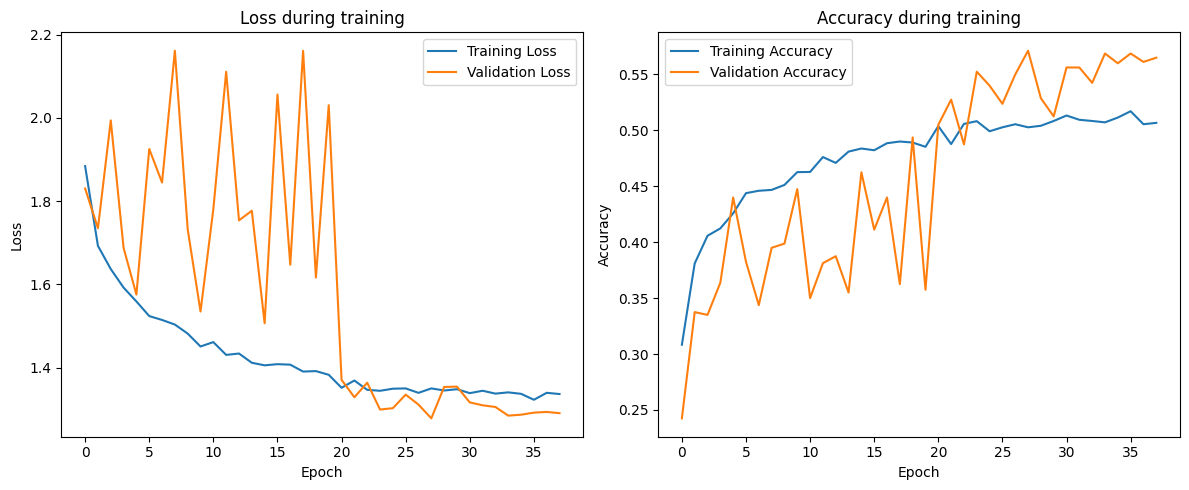

In [ ]:
# Loss and accuracy visualization during the training model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Found 822 validated image filenames belonging to 7 classes.
25/25 [==============================] - 28s 1s/step


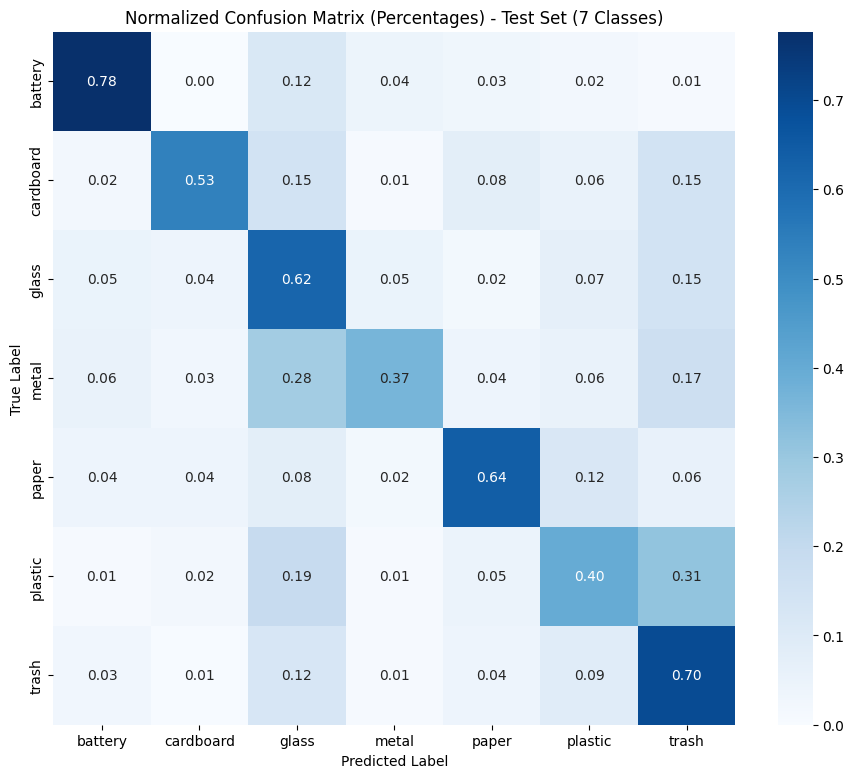

In [ ]:
# Re-load metadata and get the 7 new classes
all_classes = sorted(os.listdir(dataset_path))
classes_10 = [c for c in all_classes if c not in EXCLUDED_CLASSES]
metadata = []
for class_name in classes_10:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            metadata.append({"image_path": img_path, "class": class_name, "mapped_class": CLASS_MAPPING[class_name]})


# ImageDataGenerator for Test Set Evaluation
test_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator_eval = test_datagen_eval.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="mapped_class",  
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=new_classes,  
    seed=SEED,
    shuffle=False
)

# Load the Best Model (7 classes)
best_model = load_model('best_model_7_classes.h5')

# Obtain Predictions and True Tags for the Test Set
y_pred_test_probs = best_model.predict(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE)
y_pred_test = np.argmax(y_pred_test_probs, axis=1)
y_true_test = test_generator_eval.classes[:len(y_pred_test)]

# Calculate and Visualize the Normalized Confusion Matrix
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_normalized_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(11, 9))
sns.heatmap(cm_normalized_test, annot=True, fmt=".2f", cmap='Blues', xticklabels=new_classes, yticklabels=new_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Percentages) - Test Set (7 Classes)')
plt.show()

## Getting visualizations and evaluations for comparison, mapping to 3 classes

In [ ]:
# Count per original class (10 classes)
original_counts = df_metadata['class'].value_counts().sort_index()
print("\n• ORIGINAL Classes (10 classes):")
print(original_counts)

# Counting by mapped class (7 classes)
mapped_counts = df_metadata['mapped_class'].value_counts().sort_index()
print("\n• MAPPED Classes (7 classes):")
print(mapped_counts)

total_images = len(df_metadata)
print(f"\n• Total number of images: {total_images}")


• ORIGINAL Classes (10 classes):
class
battery         945
biological      985
brown-glass     607
cardboard       891
green-glass     629
metal           769
paper          1050
plastic         865
trash           697
white-glass     775
Name: count, dtype: int64

• MAPPED Classes (7 classes):
mapped_class
battery       945
cardboard     891
glass        2011
metal         769
paper        1050
plastic       865
trash        1682
Name: count, dtype: int64

• Total number of images: 8213


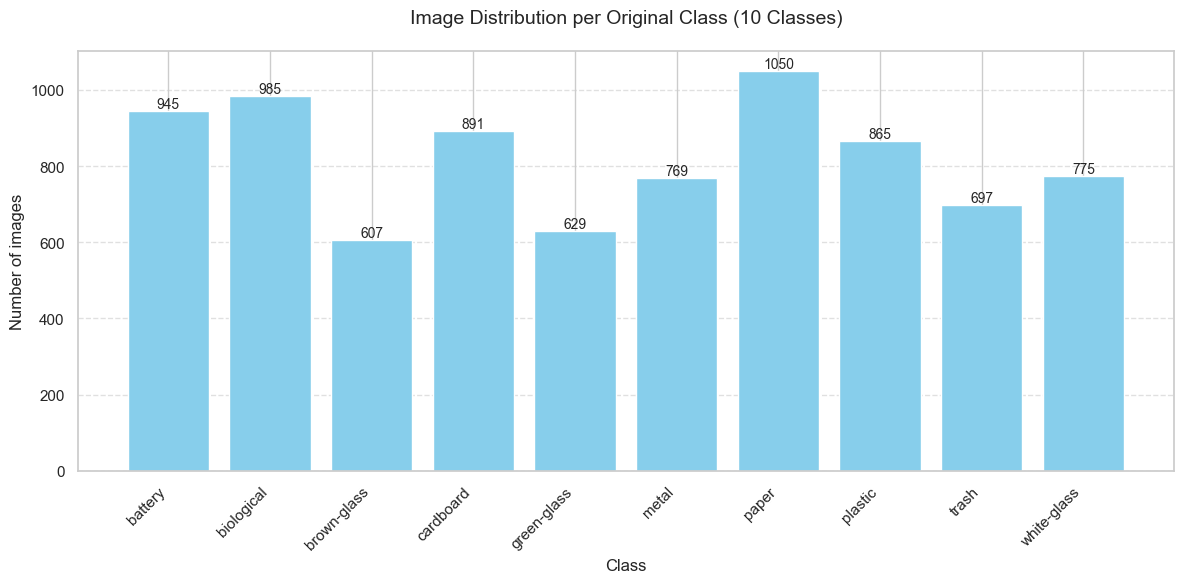

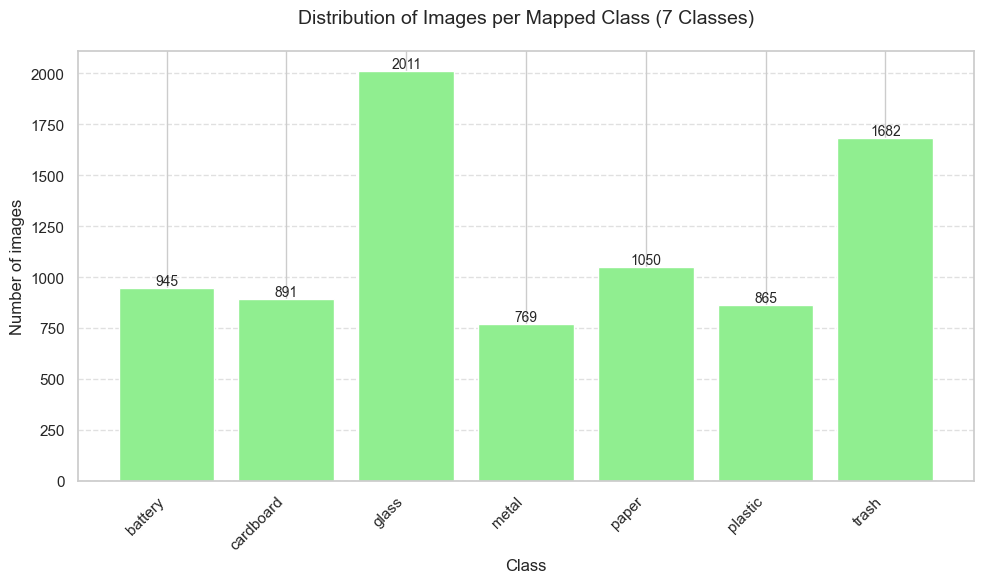


• TOTAL NUMBER OF IMAGES IN THE DATASET: 8213


In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")

plt.figure(figsize=(12, 6))
original_counts = df_metadata['class'].value_counts().sort_index()
bars_original = plt.bar(original_counts.index, original_counts.values, color='skyblue')

plt.title('Image Distribution per Original Class (10 Classes)', fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add values above the bars
for bar in bars_original:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
mapped_counts = df_metadata['mapped_class'].value_counts().sort_index()
bars_mapped = plt.bar(mapped_counts.index, mapped_counts.values, color='lightgreen')

plt.title('Distribution of Images per Mapped Class (7 Classes)', fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars_mapped:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

total_images = len(df_metadata)
print(f"\n• TOTAL NUMBER OF IMAGES IN THE DATASET: {total_images}")


• MAPPED Classes (4 classes):
mapped_class_4
glass      2011
other      3396
paper      1941
plastic     865
Name: count, dtype: int64


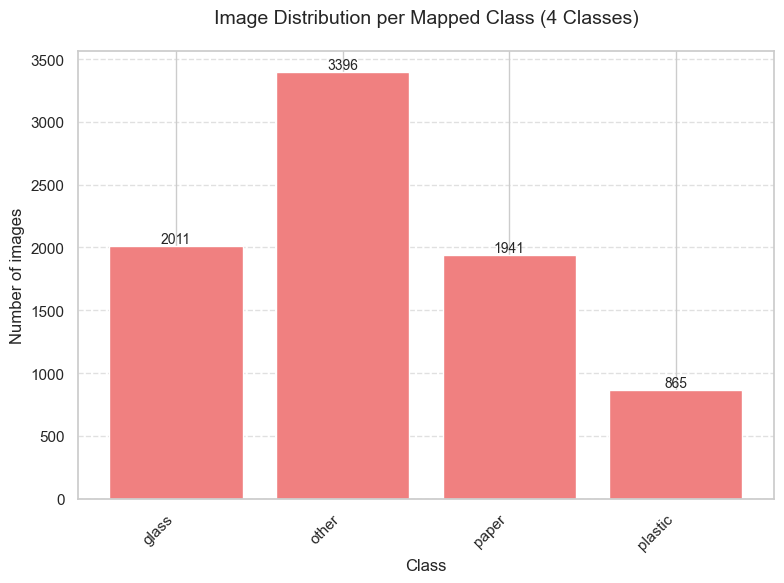

In [ ]:
# Define the mapping for 4 classes
class_mapping_4_classes = {
    'brown-glass': 'glass',
    'green-glass': 'glass',
    'white-glass': 'glass',
    'cardboard': 'paper',
    'paper': 'paper',
    'plastic': 'plastic',
    'metal': 'other',
    'battery': 'other',
    'biological': 'other',
    'trash': 'other'
}

mapped_4_classes = sorted(list(set(class_mapping_4_classes.values())))

# Map the original classes to the new 4 classes in the DataFrame
df_metadata['mapped_class_4'] = df_metadata['class'].map(class_mapping_4_classes)

# Counting by mapped class (4 classes)
mapped_4_counts = df_metadata['mapped_class_4'].value_counts().sort_index()
print("\n• MAPPED Classes (4 classes):")
print(mapped_4_counts)

plt.figure(figsize=(8, 6))
bars_mapped_4 = plt.bar(mapped_4_counts.index, mapped_4_counts.values, color='lightcoral')

plt.title('Image Distribution per Mapped Class (4 Classes)', fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars_mapped_4:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
original_classes = ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']
class_mapping3 = {
    'brown-glass': 'glass',
    'green-glass': 'glass',
    'white-glass': 'glass',
    'cardboard': 'paper',
    'paper': 'paper',
    'metal': 'plastic',
    'plastic': 'plastic',
    'battery': 'other',         
    'biological': 'other',      
    'trash': 'other'
}
mapped3_classes = sorted(list(set(class_mapping3.values())))
num_mapped3_classes = len(mapped3_classes)

# ImageDataGenerator for Test Set Evaluation
test_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator_eval = test_datagen_eval.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=original_classes, 
    seed=SEED,
    shuffle=False
)

best_model = load_model('best_model_10_classes.h5')

# Evaluation of the Model in the Test Set
loss_before, accuracy_before = best_model.evaluate(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss (before mapping): {loss_before:.4f}")
print(f"Test Accuracy (before mapping): {accuracy_before:.4f}")

# Obtain Predictions and True Tags for the Test Set
y_pred_probs = best_model.predict(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE)
y_pred_original = np.argmax(y_pred_probs, axis=1)
y_true_original = test_generator_eval.classes[:len(y_pred_original)]

# Mapping True and Predicted Tags to New Classes
y_mapped3_true = np.array([mapped3_classes.index(class_mapping3[original_classes[label]]) for label in y_true_original])
y_mapped3_pred = np.array([mapped3_classes.index(class_mapping3[original_classes[label]]) for label in y_pred_original])

# Evaluation of the Model in the Test Set (after mapping)
from sklearn.metrics import accuracy_score
accuracy_after = accuracy_score(y_mapped3_true, y_mapped3_pred)
print(f"Test Accuracy (after mapping): {accuracy_after:.4f}")

# Ranking Report (after mapping)
report_mapped3 = classification_report(y_mapped3_true, y_mapped3_pred, target_names=mapped3_classes, zero_division=0)
print("Classification Report (Test Set - after mapping):\n", report_mapped3)

Found 822 validated image filenames belonging to 10 classes.
25/25 [==============================] - 28s 1s/step - loss: 1.3027 - accuracy: 0.5913
Test Loss (before mapping): 1.3027
Test Accuracy (before mapping): 0.5913
25/25 [==============================] - 31s 1s/step
Test Accuracy (after mapping): 0.6675
Classification Report (Test Set - after mapping):
               precision    recall  f1-score   support

       glass       0.64      0.54      0.58       196
       other       0.76      0.78      0.77       262
       paper       0.69      0.74      0.72       188
     plastic       0.52      0.55      0.54       154

    accuracy                           0.67       800
   macro avg       0.65      0.65      0.65       800
weighted avg       0.67      0.67      0.67       800



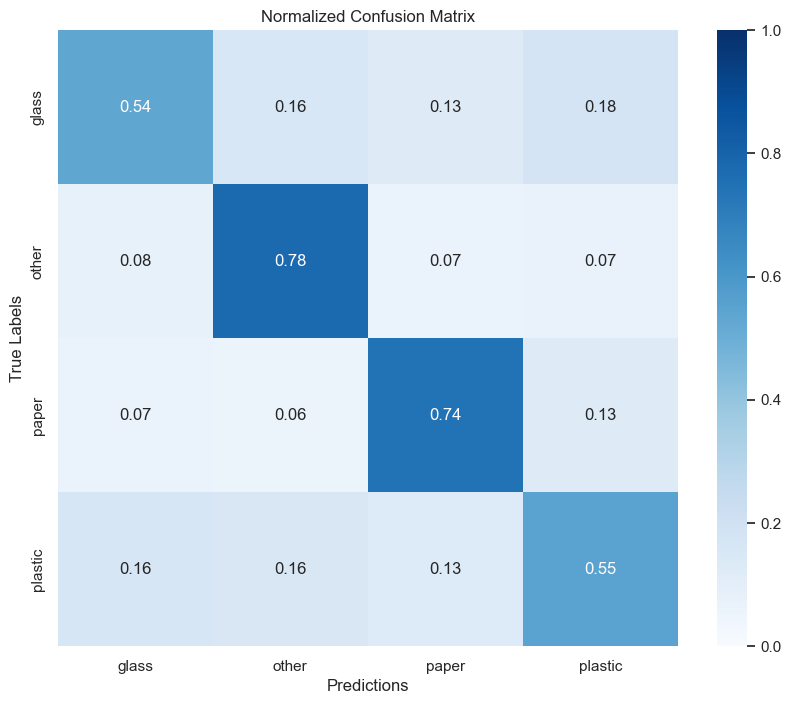

In [ ]:
# Normalized Confusion Matrix
cm = confusion_matrix(y_mapped3_true, y_mapped3_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm_normalized, 
                      annot=True, 
                      fmt='.2f', 
                      cmap='Blues', 
                      xticklabels=mapped3_classes, 
                      yticklabels=mapped3_classes,
                      vmin=0, 
                      vmax=1)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

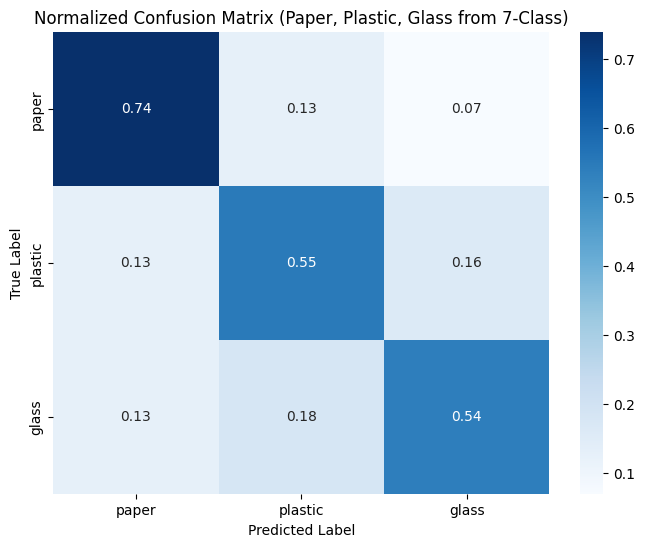

In [ ]:
classes = ['paper', 'plastic', 'glass']

original_matrix = np.array([
    [0.54, 0.16, 0.13, 0.18], 
    [0.08, 0.78, 0.07, 0.07], 
    [0.07, 0.06, 0.74, 0.13], 
    [0.16, 0.16, 0.13, 0.55]  
])

personalized_matrix = np.array([
    original_matrix[2, [2, 3, 0]],  
    original_matrix[3, [2, 3, 0]], 
    original_matrix[0, [2, 3, 0]]   # 
])

plt.figure(figsize=(8, 6))
sns.heatmap(personalized_matrix,
            annot=True,
            fmt=".2f",
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Paper, Plastic, Glass from 7-Class)')
plt.show()

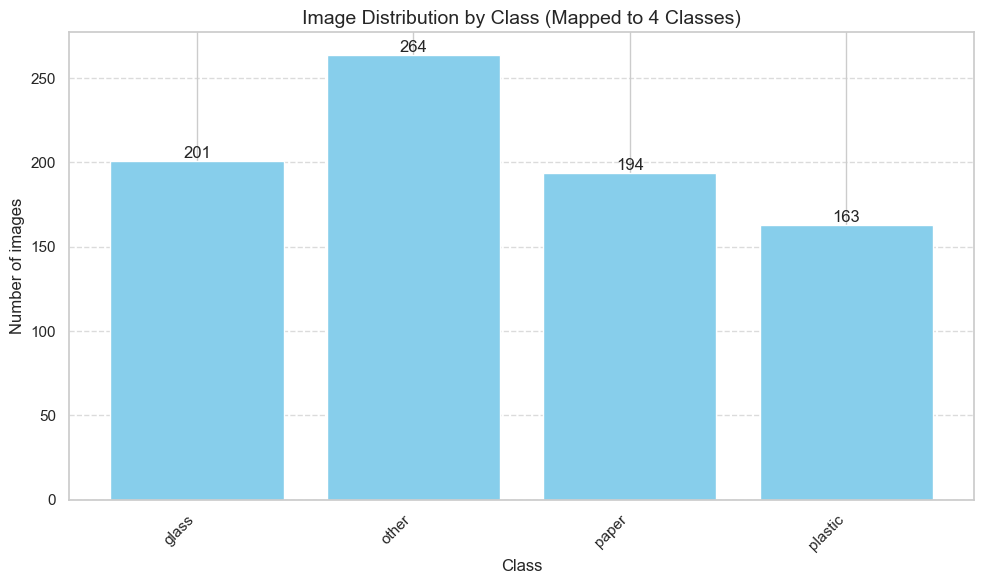

In [ ]:
# Map the original classes to the new 4 classes in the DataFrame
test_df['mapped_class'] = test_df['class'].map(class_mapping3)

# Count the number of images per mapped class
class_counts = test_df['mapped_class'].value_counts().reindex(mapped3_classes, fill_value=0)

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')

plt.title('Image Distribution by Class (Mapped to 4 Classes)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout() 
plt.show()

# EfficientNetB0

It's worth mentioning that during the project development, located in the `exploratory_notebooks` folder, we also attempted to train a new model using the EfficientNetB0 architecture. However, the results obtained from these experiments were not satisfactory compared to the model presented in this notebook. Therefore, the EfficientNetB0 training process and its outcomes have not been included in this final analysis.


# ResNet50 model merged with new data and mapped to 3 classes

### Unifying and explorying datasets

In [ ]:
# Datasets paths
dataset_path_1 = os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes')
dataset_path_2 = os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_6_classes')

# Target classes
target_classes = ['paper', 'plastic', 'glass']

In [ ]:
# Mapping for the 12-class dataset 
mapping_12_to_3 = {
    'cardboard': 'paper',
    'paper': 'paper',
    'brown-glass': 'glass',
    'green-glass': 'glass',
    'white-glass': 'glass',
    'plastic': 'plastic',
    'metal': None,  
    'biological': None,
    'trash': None,
    'clothes': None,
    'shoes': None,
    'battery': None
}

# Mapping for the 6-class dataset
mapping_6_to_3 = {
    'paper': 'paper',
    'plastic': 'plastic',
    'glass': 'glass',
    'cardboard': 'paper', 
    'metal': None,  
    'trash': None  
}

In [ ]:
def load_and_map_data(dataset_path, mapping):
    data = []
    all_classes = os.listdir(dataset_path)
    for original_class in all_classes:
        mapped_class = mapping.get(original_class)
        if mapped_class in target_classes:
            class_path = os.path.join(dataset_path, original_class)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                data.append({'image_path': img_path, 'class': mapped_class})
    return data

data_12 = load_and_map_data(dataset_path_1, mapping_12_to_3)
data_6 = load_and_map_data(dataset_path_2, mapping_6_to_3)

print(data_12)
print(data_6)

[{'image_path': 'C:\\Users\\ruben\\OneDrive\\Escritorio\\IRONHACK\\final_project\\datasets\\garbage_classification_12_classes\\garbage_classification\\brown-glass\\brown-glass1.jpg', 'class': 'glass'}, {'image_path': 'C:\\Users\\ruben\\OneDrive\\Escritorio\\IRONHACK\\final_project\\datasets\\garbage_classification_12_classes\\garbage_classification\\brown-glass\\brown-glass10.jpg', 'class': 'glass'}, {'image_path': 'C:\\Users\\ruben\\OneDrive\\Escritorio\\IRONHACK\\final_project\\datasets\\garbage_classification_12_classes\\garbage_classification\\brown-glass\\brown-glass100.jpg', 'class': 'glass'}, {'image_path': 'C:\\Users\\ruben\\OneDrive\\Escritorio\\IRONHACK\\final_project\\datasets\\garbage_classification_12_classes\\garbage_classification\\brown-glass\\brown-glass101.jpg', 'class': 'glass'}, {'image_path': 'C:\\Users\\ruben\\OneDrive\\Escritorio\\IRONHACK\\final_project\\datasets\\garbage_classification_12_classes\\garbage_classification\\brown-glass\\brown-glass102.jpg', 'class

In [ ]:
# Unifying data
combined_data = data_12 + data_6
df_combined = pd.DataFrame(combined_data)
df_combined

image_path    class
0     C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...    glass
1     C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...    glass
2     C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...    glass
3     C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...    glass
4     C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...    glass
...                                                 ...      ...
6792  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  plastic
6793  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  plastic
6794  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  plastic
6795  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  plastic
6796  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  plastic

[6797 rows x 2 columns]

C:\Users\ruben\AppData\Local\Temp\ipykernel_17860\3010428703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=initial_class_counts.index,


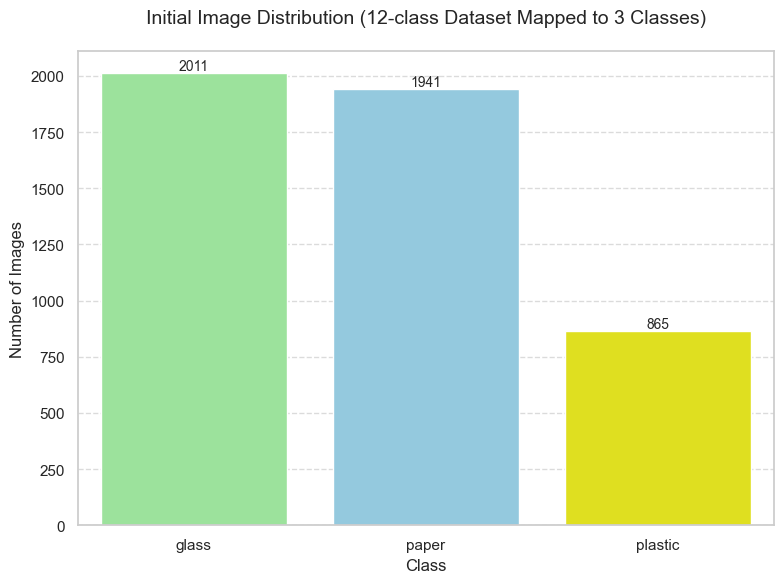


Image count from initial 12-class dataset (mapped to 3 classes)
class
glass      2011
paper      1941
plastic     865
Name: count, dtype: int64


In [ ]:
data_12 = load_and_map_data(dataset_path_1, mapping_12_to_3)
df_12 = pd.DataFrame(data_12)

initial_class_counts = df_12['class'].value_counts()

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid", palette="pastel")

ax = sns.barplot(x=initial_class_counts.index, 
                 y=initial_class_counts.values,
                 palette=['lightgreen', 'skyblue', 'yellow'],
                 width=0.8)

plt.title('Initial Image Distribution (12-class Dataset Mapped to 3 Classes)', 
          fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\nImage count from initial 12-class dataset (mapped to 3 classes)")
print(initial_class_counts)

In [ ]:
class_counts = df_combined['class'].value_counts()
print("\nClass Count:\n", class_counts)


Class Count:
 class
paper      2938
glass      2512
plastic    1347
Name: count, dtype: int64


C:\Users\ruben\AppData\Local\Temp\ipykernel_17860\1169863742.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(class_counts.keys()),


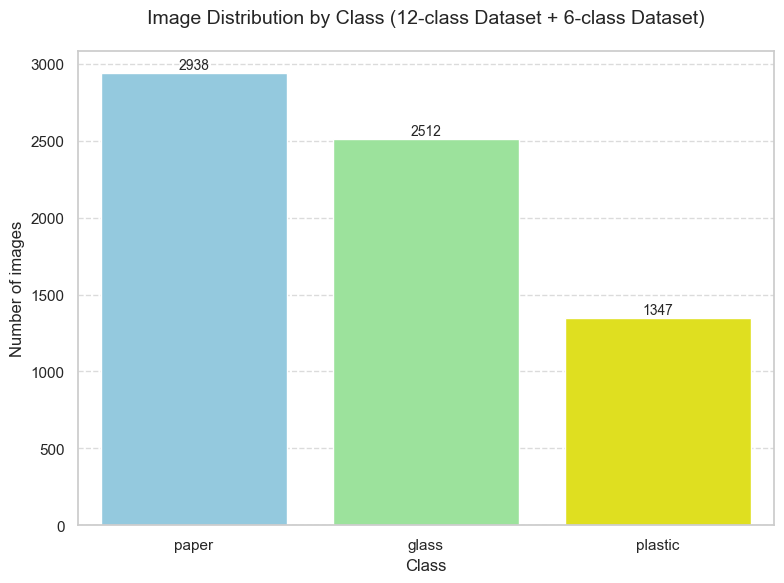

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(8, 6))

ax = sns.barplot(x=list(class_counts.keys()), 
                 y=list(class_counts.values), 
                 palette=['skyblue', 'lightgreen', 'yellow'],
                 width=0.8)  

plt.title('Image Distribution by Class (12-class Dataset + 6-class Dataset)', fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10,
                xytext=(0, 1),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
folder_path = os.path.join(os.pardir, 'data', 'raw_images', 'api_images')
target_folders = ['paper', 'plastic', 'glass']
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

image_counts = Counter()

for folder_name in target_folders:
    folder_path_full = os.path.join(folder_path, folder_name)
    count = 0
    for filename in os.listdir(folder_path_full):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            count += 1
    image_counts[folder_name] = count

print("\nImage count per folder")
for folder, count in image_counts.items():
    print(f"Folder '{folder}': {count} images")


Image count per folder
Folder 'paper': 115 images
Folder 'plastic': 292 images
Folder 'glass': 203 images


In [ ]:
api_path = os.path.join(os.pardir, 'data', 'raw_images', 'api_images')

In [ ]:
# Adding images from the Pexels path
api_data = []
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

for folder_name in target_classes:
    folder_path_full = os.path.join(api_path, folder_name)
    for filename in os.listdir(folder_path_full):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            img_path = os.path.join(folder_path_full, filename)
            api_data.append({'image_path': img_path, 'class': folder_name})

# Convert data from Pexels to DataFrame and concatenate
df_api = pd.DataFrame(api_data)
df_combined_all = pd.concat([df_combined, df_api], ignore_index=True)

print("\nDataFrame combined after adding images from API's and google images:")
print(df_combined_all.head())
print(f"Final number of rows: {len(df_combined_all)}")

# Count number of images per class in the final DataFrame
final_class_counts = df_combined_all['class'].value_counts()
print("\n-Image count per class in the final DataFrame:")
print(final_class_counts)


DataFrame combined after adding images from API's and google images:
                                          image_path  class
0  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  glass
1  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  glass
2  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  glass
3  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  glass
4  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  glass
Final number of rows: 7407

-Image count per class in the final DataFrame:
class
paper      3053
glass      2715
plastic    1639
Name: count, dtype: int64


C:\Users\ruben\AppData\Local\Temp\ipykernel_17860\4092060427.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=final_class_counts.index,


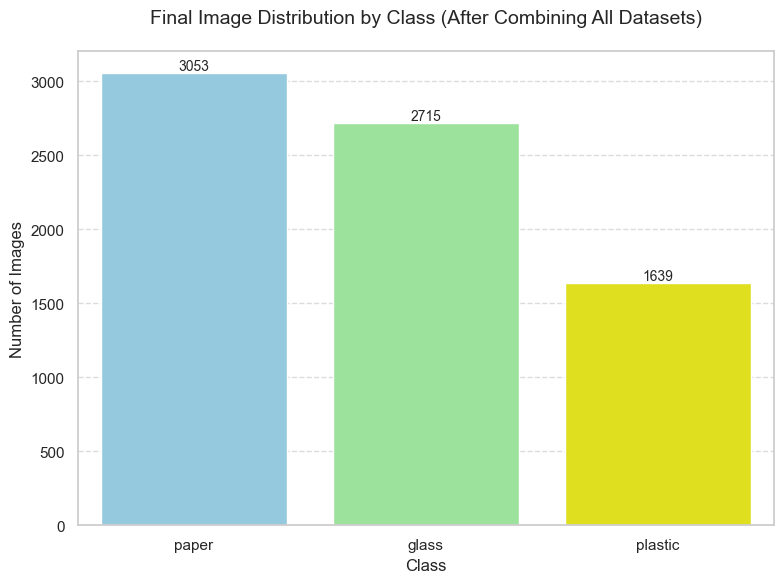

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid", palette="pastel")

# Create the bar plot
ax = sns.barplot(x=final_class_counts.index, 
                 y=final_class_counts.values,
                 palette=['skyblue', 'lightgreen', 'yellow'], width=0.8)

# Add title and labels
plt.title('Final Image Distribution by Class (After Combining All Datasets)', 
          fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=0)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=10)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Model training

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42
target_classes = ['paper', 'plastic', 'glass']

In [ ]:
train_df, temp_df = train_test_split(
    df_combined_all,
    test_size=0.2,
    random_state=SEED,
    stratify=df_combined_all['class']
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=SEED,
    stratify=temp_df['class']
)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None, 
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=target_classes,
    seed=SEED,
    shuffle=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None, 
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=target_classes,
    seed=SEED,
    shuffle=False
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,  
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=target_classes,
    seed=SEED,
    shuffle=False
)

Found 5919 validated image filenames belonging to 3 classes.
Found 741 validated image filenames belonging to 3 classes.


c:\Users\ruben\anaconda3\envs\tf_python39\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 6 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 741 validated image filenames belonging to 3 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(target_classes), activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpoint_filepath = 'best_model_3_classes.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)
callbacks_list = [early_stopping, lr_scheduler, model_checkpoint]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50
184/184 [==============================] - ETA: 0s - loss: 1.1417 - accuracy: 0.4693
Epoch 1: val_loss improved from inf to 1.20251, saving model to best_model_3_classes.h5
184/184 [==============================] - 257s 1s/step - loss: 1.1417 - accuracy: 0.4693 - val_loss: 1.2025 - val_accuracy: 0.3709 - lr: 1.0000e-04
Epoch 2/50
184/184 [==============================] - ETA: 0s - loss: 1.0373 - accuracy: 0.5132
Epoch 2: val_loss improved from 1.20251 to 0.97963, saving model to best_model_3_classes.h5
184/184 [==============================] - 284s 2s/step - loss: 1.0373 - accuracy: 0.5132 - val_loss: 0.9796 - val_accuracy: 0.4837 - lr: 1.0000e-04
Epoch 3/50
184/184 [==============================] - ETA: 0s - loss: 0.9945 - accuracy: 0.5471
Epoch 3: val_loss did not improve from 0.97963
184/184 [==============================] - 288s 2s/step - loss: 0.9945 - accuracy: 0.5471 - val_loss: 1.0281 - val_accuracy: 0.5272 - lr: 1.0000e-04
Epoch 4/50
184/184 [==================

### Evaluating model

In [ ]:
# Load the best saved model
best_model = load_model('best_model_3_classes.h5')

# Evaluate the model in the test generator
loss, accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report using test_generator
y_pred_probs = best_model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for i in range(test_generator.samples // BATCH_SIZE):
    _, labels = test_generator[i]
    y_true.extend(np.argmax(labels, axis=1))
y_true = np.array(y_true)

report = classification_report(y_true, y_pred, target_names=target_classes, zero_division=0)
print("Classification Report (Test Set):\n", report)

23/23 [==============================] - 28s 1s/step - loss: 0.7988 - accuracy: 0.6658
Test Loss: 0.7988
Test Accuracy: 0.6658
23/23 [==============================] - 29s 1s/step
Classification Report (Test Set):
               precision    recall  f1-score   support

       paper       0.68      0.74      0.71       303
     plastic       0.60      0.57      0.58       162
       glass       0.69      0.64      0.66       271

    accuracy                           0.67       736
   macro avg       0.66      0.65      0.65       736
weighted avg       0.67      0.67      0.66       736



In [ ]:
loss_val, accuracy_val = best_model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE, verbose=0)
print(f"Validation Loss: {loss_val:.4f}")
print(f"Validation Accuracy: {accuracy_val:.4f}")

y_pred_val_probs = best_model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
y_pred_val = np.argmax(y_pred_val_probs, axis=1)

y_true_val = []
for i in range(validation_generator.samples // BATCH_SIZE):
    _, labels = validation_generator[i]
    y_true_val.extend(np.argmax(labels, axis=1))
y_true_val = np.array(y_true_val)

report_val = classification_report(y_true_val, y_pred_val, target_names=target_classes, zero_division=0)
print("Classification Report (Validation Set):\n", report_val)

Validation Loss: 0.8010
Validation Accuracy: 0.6440
23/23 [==============================] - 31s 1s/step
Classification Report (Validation Set):
               precision    recall  f1-score   support

       paper       0.68      0.77      0.72       303
     plastic       0.51      0.43      0.46       164
       glass       0.67      0.64      0.65       269

    accuracy                           0.64       736
   macro avg       0.62      0.61      0.61       736
weighted avg       0.64      0.64      0.64       736



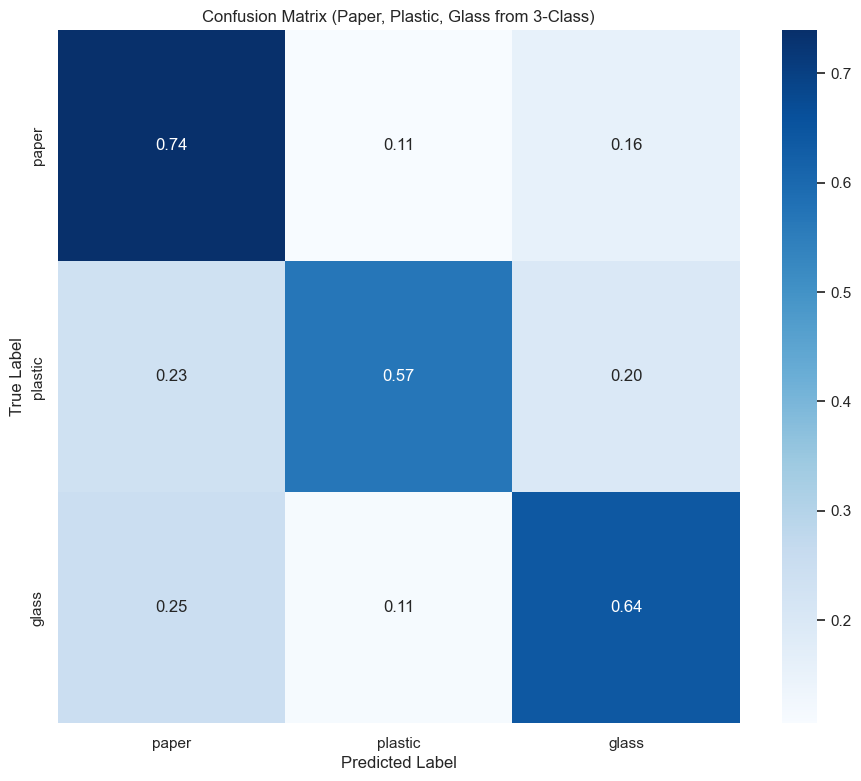

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(11, 9))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Paper, Plastic, Glass from 3-Class)')
plt.show()

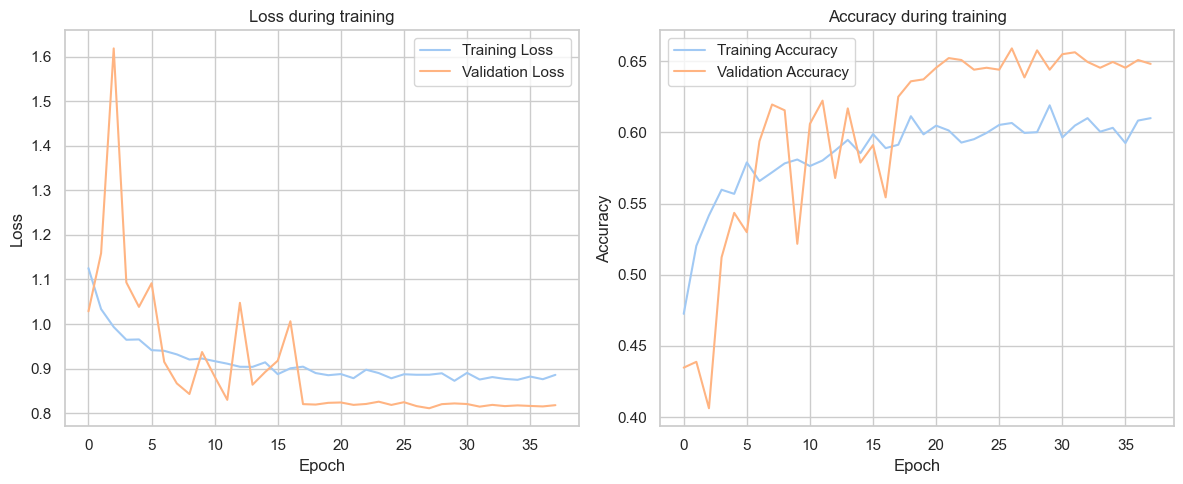

In [ ]:
# Loss and accuracy visualization during the training model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()